In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Testing the Forward Model with actions following an uniform distribution over thrust vector coordinates

- The simulator did not take into account discrete actions, thus the forward model had to learn to ignore them
- Training was done over 1000 epochs. The model began to overfit the data after 200 epochs, thus I kept the checkpoint at epoch 160 which had good performances

In [2]:
#Just some useful functions

def loadData(filename):
    f = open(filename,'r')
    data = []
    lines = f.readlines()
    for line in lines:
        data.append(float(line))
    f.close()
    return np.array(data)

def smoothData(data,n):
    avData = [0 for i in range(len(data))]
    avData[0:n] = [np.mean(data[0:i+1]) for i in range(n)]
    avData[n:] = [np.mean(data[i-n:i+1]) for i in range(n,len(data))]
    return np.array(avData)

def plotData(data,datalabel):
    xaxis = [i for i in range(len(data))]        
    plt.plot(xaxis,data,label=datalabel)
    plt.legend()
    
def gbprHist(data):
    print("\nAverage reward:\n")
    print(np.mean(data))
    print("\nMax reward:\n")
    print(np.max(data))
    print("\n% of trials that have succesfully dodged the planet:\n")
    print(len(data[data>=0])/len(data)*100)
    print("\n% of trials that have reached a waypoint:\n")
    print(len(data[data>0])/len(data)*100)
    plt.hist(data, bins = 40)
    plt.xlabel('Reward')
    plt.ylabel('Trials')
    plt.show()
    plt.hist(data[data>=0],bins=20)
    plt.xlabel('Reward')
    plt.ylabel('Trials')
    plt.show()
    
def gbpeHist(data):
    print("Average error:\n")
    print(np.mean(data))
    plt.hist(data,bins=50)
    plt.xlabel("Position error in pixels")
    plt.ylabel("Trials")
    plt.show()

# Map pool generation

I generated 1000 maps with 1 planet and 3 waypoints
```
./project -cmd=ssmpgen -mp=../Starship/Maps/1pset1/ -nmaps=1000 -rwp=20
```

# Dataset Generation

The dataset was generated using the default action distribution (plotted bellow) and using the following command:

```
./project -cmd=ssdsgen -mp=../Starship/Maps/1pset1/ -n=50000 -nmaps=1000 -T=40 -wp=0.5 -trp=0.99 -dist=0 -woda
```

### **Bellow is plotted the average distribution that the actions are following.**

Note that the model is trained using the X and Y (cartesian) coordinates. 

Normally X and Y coordinates range from -1 to 1. I chose to widen this range to -1.5, 1.5 so that the forward model understands that thrust power is capped to 1. If I do not do so, actions are overencouraged to reach their bounds by the optimizer.

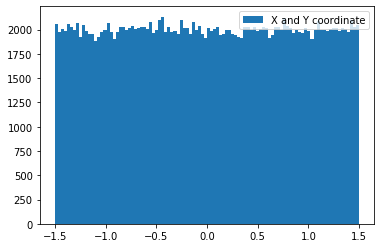

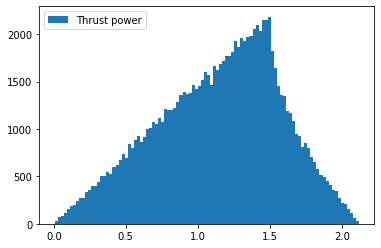

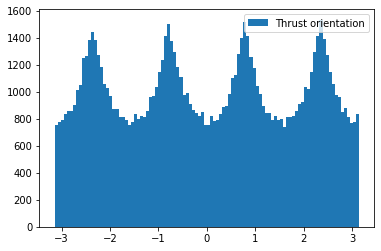

In [3]:
n=100000
xy = 1.5*(np.random.rand(n,2)*2-1)
r = np.sqrt(xy[:,0]**2+xy[:,1]**2)
sign = ((xy[:,1]/r)>0).astype(int)*2-1
theta = sign*np.arccos(xy[:,0]/r)
plt.hist(xy.flatten(),bins=100,label="X and Y coordinate")
plt.legend()
plt.show()
plt.hist(r.flatten(),bins=100,label="Thrust power")
plt.legend()
plt.show()
plt.hist(theta.flatten(),bins=100, label="Thrust orientation")
plt.legend()
plt.show()

# Forward Model Training

Training was done using the following command:
```
./project -cmd=ssmbfm -mdl=../tests/baseline/model -tag=md1 -lr=0.0001 -beta=10 -bs=128 -e=1000 -mp=../Starship/Maps/1pset1/ -lp1=0.1
```
Bellow are plotted some informative curves on the training process
Training is quite noisy. You can tweek the smooth parameter to hide the noise. You can also chose the iteration at which to start the plotting to visualize better the loss decrease. 

If you do your own training, you can find these files in the temp directory with the name "transitionLoss" and "rewardLoss". Beware, these files are overwritten whenever a new training is started. 

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


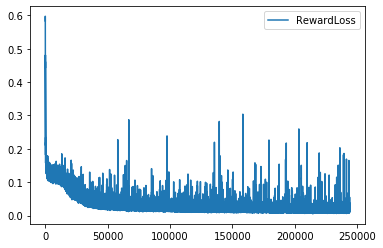

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


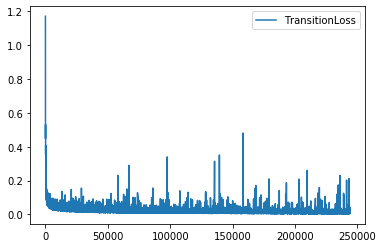

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


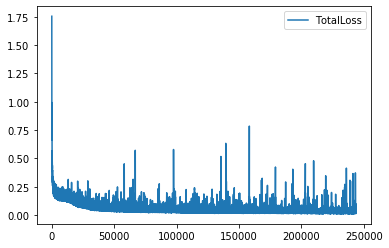

In [4]:
smooth = 1
start = 0
end = int(len(loadData("rLoss"))*160/1000)
rLoss = loadData("rLoss")[start:end]
sLoss = loadData("tLoss")[start:end]
tLoss = (rLoss+sLoss)[start:end]
plotData(smoothData(rLoss,smooth),"RewardLoss")
plt.show();
plotData(smoothData(sLoss,smooth),"TransitionLoss")
plt.show();
tLoss = rLoss+sLoss
plotData(smoothData(tLoss,smooth),"TotalLoss")
plt.show()

Bellow you see the average error between the forward model's predictions and the test set at every epoch. You can see that the model is overfitting the data after ~200 epochs. A larger dataset would reduce that effect. 

If you do your own training, you can find these files in the temp directory with the following names:
- tep_mse+tag for the position error
- tev_mse+tag for the velocity error
- ter_mse+tag for the reward error

tag is a string that you give on the command line with the flag "tag". If you use the same command as mine, tag=md1

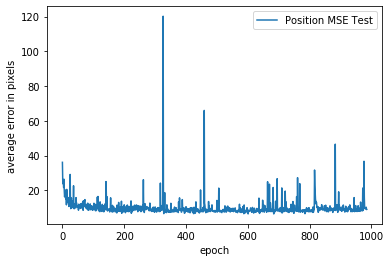

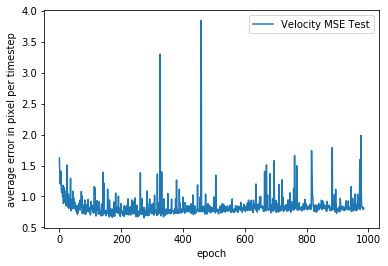

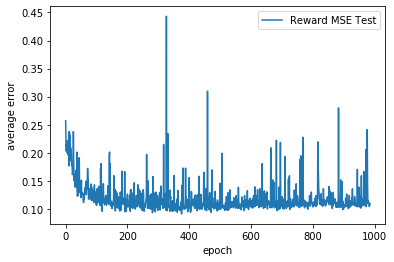

In [5]:
ptemse = loadData("pMSE")
avErr = np.mean(ptemse[-40:])
plotData(ptemse,"Position MSE Test")
plt.xlabel("epoch")
plt.ylabel("average error in pixels")
plt.show()
vtemse = loadData("vMSE")
plotData(vtemse,"Velocity MSE Test")
plt.xlabel("epoch")
plt.ylabel("average error in pixel per timestep")
plt.show()
rtemse = loadData("rMSE")
plotData(rtemse,"Reward MSE Test")
plt.xlabel("epoch")
plt.ylabel("average error")
plt.show()

# Gradient Based Planner

Bellow I have executed 300 times the GBP and measured the amount of reward collected as well as the position error between the forward model during inference and the simulator.

I did this with four sets of parameters. 

## Test 1

- Learning rate: 0.01 
- Number of rollouts: 100
- Number of gradient steps: 0

```
./project -cmd-ssmbtest -mdl=../tests/baseline/model -mp=../Starship/Maps/1pset1/test/ -f=../tests/baseline/0gs -n=300 -K=100 -lr=0.01 -gs=0 -T=80 
```


Average reward:

-44.44

Max reward:

6.0

% of trials that have succesfully dodged the planet:

12.333333333333334

% of trials that have reached a waypoint:

2.3333333333333335


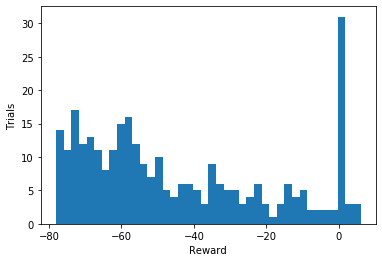

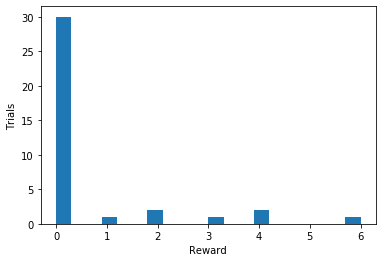

Average error:

13.371986099999999


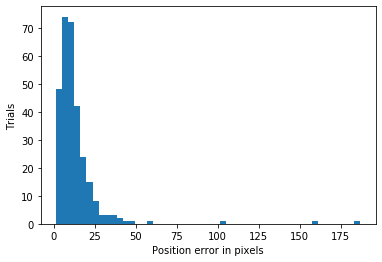

In [6]:
rew = loadData("0gs_score")
gbprHist(rew)
err = loadData("0gs_error")
gbpeHist(err)

## Test 2

- Learning rate: 0.01 
- Number of rollouts: 10
- Number of gradient steps: 100

```
./project -cmd-ssmbtest -mdl=../tests/baseline/model -mp=../Starship/Maps/1pset1/test/ -f=../tests/baseline/10rlt -n=300 -K=10 -lr=0.01 -gs=100 -T=80 
```


Average reward:

-16.284584980237153

Max reward:

9.0

% of trials that have succesfully dodged the planet:

55.73122529644269

% of trials that have reached a waypoint:

20.55335968379447


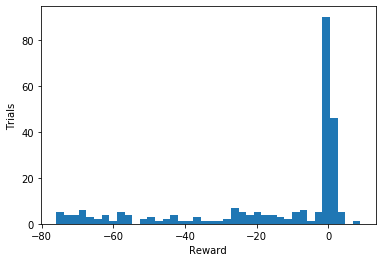

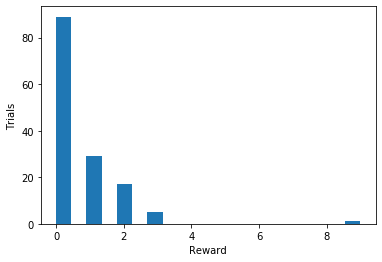

Average error:

45.371298458498025


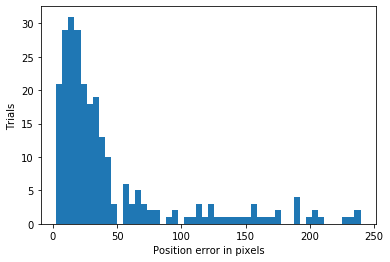

In [10]:
rew = loadData("10rlt_score")
gbprHist(rew)
err = loadData("10rlt_error")
gbpeHist(err)

## Test 3

- Learning rate: 0.01 
- Number of rollouts: 100
- Number of gradient steps: 100

```
./project -cmd-ssmbtest -mdl=../tests/baseline/model -mp=../Starship/Maps/1pset1/test/ -f=../tests/baseline/100rlt -n=300 -K=100 -lr=0.01 -gs=100 -T=80 
```


Average reward:

-3.88

Max reward:

10.0

% of trials that have succesfully dodged the planet:

84.0

% of trials that have reached a waypoint:

45.33333333333333


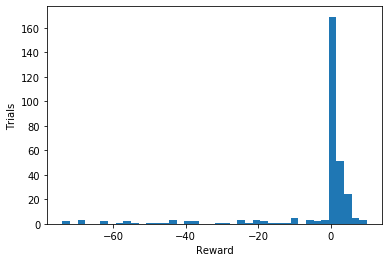

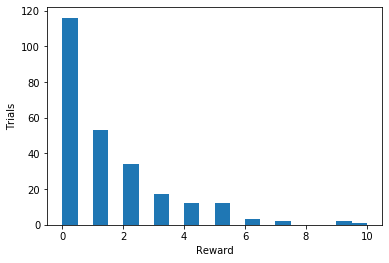

Average error:

44.178417833333334


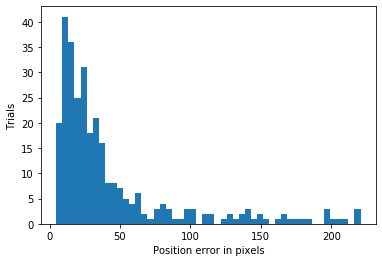

In [8]:
data = loadData("100rlt_score")
gbprHist(data)
err = loadData("100rlt_error")
gbpeHist(err)

# Commentary

We can make several observations from these plots: 

- The GBP agent makes a significant progress compared to the random agent. In the test 3, the agent is able to avoid the planet most of the time and reaches the waypoint for at least one timestep every trial out of two. 

- Increasing the number of rollouts allows to achieve better performances at low computational cost. 

- Performing gradient steps at a rather high learning rate causes the model to drastically lose in accuracy as the distance between the optimized actions distribution and the action distribution on which the model was trained increases. This shows that our forward model as overfitted our dataset action wise. This could potentially have a huge impact on the performances of GBP. A high error will cause the agent to believe it as avoided the planet when it has actually crashed. A ~20 pixel error will cause the agent to mislocate itself relatively to the waypoint since the waypoint is relatively small ! (40 pixel diameter)

# Testing action wise overfitting

When I look closer at the action sequence GBP returns with test 3, I see that in more than 50% of the time, thrust values have reached their maximal/minimal value. Testing our model with actions tensor filled with the same value k and making k vary should give us a good idea of what is going on: 

```
./project -cmd=ssaof -mdl=../tests/baseline/model -f=../tests/baseline/aof i=300 -mp=../Starship/Maps/1pset3/ -nmaps=1000 -n=1000 -T=40 -trp=0.01 -wp=0 -dist=10 -woda

```

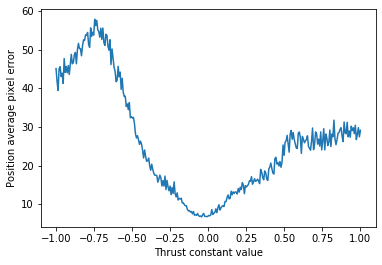

In [9]:
dat = loadData("aof")
absc = np.linspace(-1,1,len(dat))
plt.plot(absc,dat)
plt.xlabel("Thrust constant value")
plt.ylabel("Position average pixel error")
plt.show()

It is clear that there is a problem with the forward model. It has been trained with actions following an uniform distribution ranging from -1.5 and 1.5 and reaches makes that 10 pixel error on a test set with the same distribution. However it is enable to achieve a similar perfomance with distributions that are not uniform even if they are within the -1.5 1.5 range. 

If GBP outputs actions equal to constant thrust in one direction, the model will make mistakes that are almost 10 times bigger than it should, which causes a big loss in performance. 

Also, why is the model doing well only when the actions are all set to 0? 

To go further in my investigation, I trained another model with the same type of dataset. At every epoch, I tested my model on the test set and on 3 other test sets with alpha = 0, 0.5 and 1: 

![Action overfit](overfit.png)

I find several things interesting: 

- Alpha = 0 globaly does not suffer from any performance decrease compared to the original test set
- The Alpha = 0.5 and alpha = 1 curves seem to undergo the same performance increase or decrease during weight update than the original test set. 
- The Alpha = 0.5 and alpha = 1 MSE curves are continuously decreasing without giving any sign of increasing. It appears to me that there only is an offset between them and the original test set. Is it really overfitting ?
